#<b> Movie Recommendation Systems</b>
The main goal of this project is to build a recommendation system that recommends movies to users. In this project, recommendations are provided based on the movie name provided by user and his preferences and popularity of movies. 
- A simple recommendation engine is implemented by calculating weighted ratings. 
- A content based recommendation algorithm is implemented using genres, keywords and cast and crew information.
- I have applied the SVD algorithm for collaborative filtering using the surprise library. I predicted ratings of movies using SVD algorithm.
- At last, a hybrid recommendation system is created combining the above two techniques to get even better results.

## <b>Data Preparation and Preprocessing</b>

In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
import math
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy import stats
from ast import literal_eval

In [3]:
!pip install wordcloud

In [4]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from wordcloud import WordCloud, STOPWORDS

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [6]:
!pip install scikit-surprise

     |████████████████████████████████| 11.8MB 317kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670928 sha256=7ffc808d0ba1c41dcf87ac86e39456c867a5bcc9f3ab090d1f2a8e486c2d1a30
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [7]:
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Loading the datasets and creating dataframes
df= pd.read_csv('/content/drive/My Drive/ibm_project/movies_metadata.csv',
               dtype={'vote_count': 'float64','vote_average': 'float64','revenue': 'float64'},
               low_memory=False)
links= pd.read_csv('/content/drive/My Drive/ibm_project/links_small.csv')

In [10]:
ratings_df= pd.read_csv('/content/drive/My Drive/ibm_project/ratings_small.csv')
cast_crew= pd.read_csv('/content/drive/My Drive/ibm_project/credits.csv')
keywords_df= pd.read_csv('/content/drive/My Drive/ibm_project/keywords.csv')

In [11]:
df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [12]:
df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [13]:
df['status'].value_counts()

Released           45014
Rumored              230
Post Production       98
In Production         20
Planned               15
Canceled               2
Name: status, dtype: int64

In [14]:
df=df[df['status']=='Released']

In [15]:
df['status'].value_counts()

Released    45014
Name: status, dtype: int64

In [16]:
df['adult'].value_counts()

False    45006
True         8
Name: adult, dtype: int64

In [17]:
df['original_title'].sample(10)

4689                       Va savoir
17382                    Dreamkiller
44451    The Worst of Faces of Death
30120                     Sarkar Raj
29325            Swearnet: The Movie
36587         Vai Que Cola - O Filme
14170            The Silver Stallion
38965                      Film Noir
13307                           Fuel
12231                 Goodbye Bafana
Name: original_title, dtype: object

In [18]:
df['spoken_languages'].value_counts().head(15)

[{'iso_639_1': 'en', 'name': 'English'}]                                             22203
[]                                                                                    3756
[{'iso_639_1': 'fr', 'name': 'Français'}]                                             1835
[{'iso_639_1': 'ja', 'name': '日本語'}]                                                  1280
[{'iso_639_1': 'it', 'name': 'Italiano'}]                                             1204
[{'iso_639_1': 'es', 'name': 'Español'}]                                               892
[{'iso_639_1': 'ru', 'name': 'Pусский'}]                                               797
[{'iso_639_1': 'de', 'name': 'Deutsch'}]                                               753
[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'fr', 'name': 'Français'}]      678
[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'es', 'name': 'Español'}]       569
[{'iso_639_1': 'hi', 'name': 'हिन्दी'}]                                                472

In [19]:
df.drop(columns=['original_title','video','homepage','budget','status','adult','poster_path','spoken_languages','runtime','imdb_id']
        ,inplace=True)

In [20]:
pd.set_option('display.max_colwidth', 50)

In [21]:
title = df['title']
df.drop(labels=['title'], axis=1,inplace = True)
df.insert(0, 'title', title)
df.head()

,title,belongs_to_collection,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,tagline,vote_average,vote_count
0,Toy Story,"{'id': 10194, 'name': 'Toy Story Collection', ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,NaN,7.7,5415.0
1,Jumanji,NaN,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,Roll the dice and unleash the excitement!,6.9,2413.0
2,Grumpier Old Men,"{'id': 119050, 'name': 'Grumpy Old Men Collect...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0
3,Waiting to Exhale,NaN,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,Friends are the people who let you be yourself...,6.1,34.0
4,Father of the Bride Part II,"{'id': 96871, 'name': 'Father of the Bride Col...","[{'id': 35, 'name': 'Comedy'}]",11862,en,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,Just When His World Is Back To Normal... He's ...,5.7,173.0


In [22]:
df['year']=pd.to_datetime(df['release_date'], errors='coerce').apply(lambda y: str(y).split('-')[0] if y != np.nan else np.nan)

In [23]:
df.drop('release_date',axis=1,inplace=True)

In [24]:
df.isnull().sum()

title                        0
belongs_to_collection    40548
genres                       0
id                           0
original_language           10
overview                   920
popularity                   0
production_companies         0
production_countries         0
revenue                      0
tagline                  24714
vote_average                 0
vote_count                   0
year                         0
dtype: int64

In [25]:
def clean_data(x):
    try:
        return float(x)
    except:
        return np.nan

In [26]:
df['popularity'] = df['popularity'].apply(clean_data).astype('float')

In [27]:
df['vote_count'] = df['vote_count'].apply(clean_data).astype('float')
df['vote_average'] = df['vote_average'].apply(clean_data).astype('float')

In [28]:
df.head()

,title,belongs_to_collection,genres,id,original_language,overview,popularity,production_companies,production_countries,revenue,tagline,vote_average,vote_count,year
0,Toy Story,"{'id': 10194, 'name': 'Toy Story Collection', ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",373554033.0,NaN,7.7,5415.0,1995
1,Jumanji,NaN,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",262797249.0,Roll the dice and unleash the excitement!,6.9,2413.0,1995
2,Grumpier Old Men,"{'id': 119050, 'name': 'Grumpy Old Men Collect...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,A family wedding reignites the ancient feud be...,11.712900,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",0.0,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,1995
3,Waiting to Exhale,NaN,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",81452156.0,Friends are the people who let you be yourself...,6.1,34.0,1995
4,Father of the Bride Part II,"{'id': 96871, 'name': 'Father of the Bride Col...","[{'id': 35, 'name': 'Comedy'}]",11862,en,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",76578911.0,Just When His World Is Back To Normal... He's ...,5.7,173.0,1995


In [29]:
df.drop('production_countries',axis=1,inplace=True)

In [30]:
df['production_companies'] = df['production_companies'].fillna('[]').apply(literal_eval)

In [31]:
df['vote_average'].replace(0,np.nan,inplace=True)

In [32]:
fran = df[df['belongs_to_collection'].notnull()]
fran['belongs_to_collection'] = fran['belongs_to_collection'].apply(literal_eval).apply(lambda y: y['name']
                                                                                       if isinstance(y, dict) else np.nan)
fran = fran[fran['belongs_to_collection'].notnull()][['title','belongs_to_collection','revenue']]

In [33]:
fran.rename(columns={"belongs_to_collection": "franchise_name"},inplace=True)

In [34]:
fran.head()

,title,franchise_name,revenue
0,Toy Story,Toy Story Collection,373554033.0
2,Grumpier Old Men,Grumpy Old Men Collection,0.0
4,Father of the Bride Part II,Father of the Bride Collection,76578911.0
9,GoldenEye,James Bond Collection,352194034.0
12,Balto,Balto Collection,11348324.0


In [35]:
df['revenue'].describe()

count    4.501400e+04
mean     1.131890e+07
std      6.464051e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.787965e+09
Name: revenue, dtype: float64

In [36]:
df[df['revenue']==0].shape

(37619, 13)

In [37]:
df['revenue'] = df['revenue'].replace(0, np.nan)

In [38]:
df.head()

,title,belongs_to_collection,genres,id,original_language,overview,popularity,production_companies,revenue,tagline,vote_average,vote_count,year
0,Toy Story,"{'id': 10194, 'name': 'Toy Story Collection', ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]",373554033.0,NaN,7.7,5415.0,1995
1,Jumanji,NaN,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",262797249.0,Roll the dice and unleash the excitement!,6.9,2413.0,1995
2,Grumpier Old Men,"{'id': 119050, 'name': 'Grumpy Old Men Collect...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,A family wedding reignites the ancient feud be...,11.712900,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",NaN,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,1995
3,Waiting to Exhale,NaN,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,81452156.0,Friends are the people who let you be yourself...,6.1,34.0,1995
4,Father of the Bride Part II,"{'id': 96871, 'name': 'Father of the Bride Col...","[{'id': 35, 'name': 'Comedy'}]",11862,en,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...",76578911.0,Just When His World Is Back To Normal... He's ...,5.7,173.0,1995


In [39]:
links.head(10)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
5,6,113277,949.0
6,7,114319,11860.0
7,8,112302,45325.0
8,9,114576,9091.0
9,10,113189,710.0


In [40]:
ratings_df.head(10)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [41]:
ratings_df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [42]:
ratings_df.drop('timestamp',axis=1,inplace=True)

In [43]:
cast_crew.head(10)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862
5,"[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de...",949
6,"[{'cast_id': 1, 'character': 'Linus Larrabee',...","[{'credit_id': '52fe44959251416c75039da9', 'de...",11860
7,"[{'cast_id': 2, 'character': 'Tom Sawyer', 'cr...","[{'credit_id': '52fe46bdc3a36847f810f797', 'de...",45325
8,"[{'cast_id': 1, 'character': 'Darren Francis T...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de...",9091
9,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '52fe426ec3a36847f801e14b', 'de...",710


In [44]:
keywords_df.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


## <b> Data Visualization and Exploratory Data Analysis </b>

### Most Popular Movies

In [45]:
df['popularity'].describe()

count    45014.000000
mean         2.939093
std          6.023441
min          0.000000
25%          0.391015
50%          1.135734
75%          3.730199
max        547.488298
Name: popularity, dtype: float64

In [46]:
df[['year','title', 'popularity']].sort_values('popularity', ascending=False).head(10)

,year,title,popularity
30700,2015,Minions,547.488298
33356,2017,Wonder Woman,294.337037
42222,2017,Beauty and the Beast,287.253654
43644,2017,Baby Driver,228.032744
24455,2014,Big Hero 6,213.849907
26564,2016,Deadpool,187.860492
26566,2017,Guardians of the Galaxy Vol. 2,185.330992
14551,2009,Avatar,185.070892
24351,2014,John Wick,183.870374
23675,2014,Gone Girl,154.801009


### Most Voted On Movies

In [47]:
df[['title', 'vote_count']].sort_values('vote_count', ascending=False).head(10)

,title,vote_count
15480,Inception,14075.0
12481,The Dark Knight,12269.0
14551,Avatar,12114.0
17818,The Avengers,12000.0
26564,Deadpool,11444.0
22879,Interstellar,11187.0
20051,Django Unchained,10297.0
23753,Guardians of the Galaxy,10014.0
2843,Fight Club,9678.0
18244,The Hunger Games,9634.0


### Vote Average

In [48]:
df['vote_average'].describe()

count    42082.000000
mean         6.015503
std          1.252930
min          0.500000
25%          5.300000
50%          6.100000
75%          6.900000
max         10.000000
Name: vote_average, dtype: float64

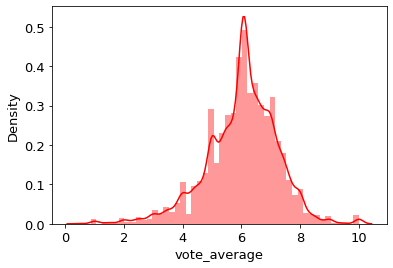

In [49]:
matplotlib.rcParams['font.size'] = 13
sns.distplot(df['vote_average'].fillna(df['vote_average'].median()),color='red');

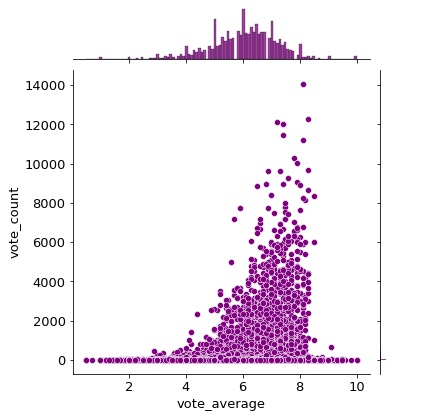

In [50]:
sns.jointplot(x='vote_average', y='vote_count', data=df,color='purple');

### Genres

In [51]:
df['genres'] = df['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] 
                                                                   if isinstance(x, list) else [])

In [52]:
genres = df.apply(lambda i: pd.Series(i['genres']),axis=1).stack().reset_index(level=1, drop=True)
genres.name = 'genre'
genres.head(10)

0    Animation
0       Comedy
0       Family
1    Adventure
1      Fantasy
1       Family
2      Romance
2       Comedy
3       Comedy
3        Drama
Name: genre, dtype: object

In [53]:
genres_df = df.drop('genres', axis=1)[['title','year']].join(genres)
genres_df

,title,year,genre
0,Toy Story,1995,Animation
0,Toy Story,1995,Comedy
0,Toy Story,1995,Family
1,Jumanji,1995,Adventure
1,Jumanji,1995,Fantasy
...,...,...,...
45463,Betrayal,2003,Action
45463,Betrayal,2003,Drama
45463,Betrayal,2003,Thriller
45464,Satan Triumphant,1917,NaN


In [54]:
# The number of different genres in the data
genres_df['genre'].value_counts().shape[0]

20

#### Most Popular Genres

In [55]:
popular_genre = pd.DataFrame(genres_df['genre'].value_counts()).reset_index()
popular_genre.columns = ['genre', 'movies']
popular_genre.head(10)

,genre,movies
0,Drama,20078
1,Comedy,13079
2,Thriller,7571
3,Romance,6668
4,Action,6546
5,Horror,4636
6,Crime,4286
7,Documentary,3874
8,Adventure,3474
9,Science Fiction,3018


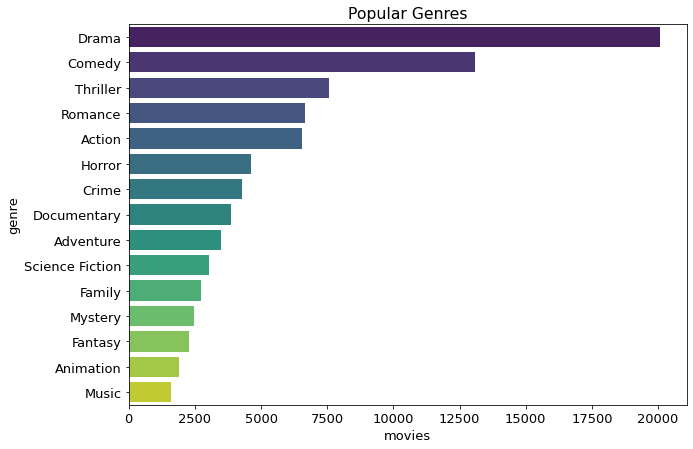

In [56]:
plt.figure(figsize=(10,7))
sns.barplot('movies','genre', data=popular_genre.head(15),palette='viridis')
plt.title('Popular Genres')
plt.show();

In [57]:
sns.set_style("whitegrid")

### Number of Movies by Year

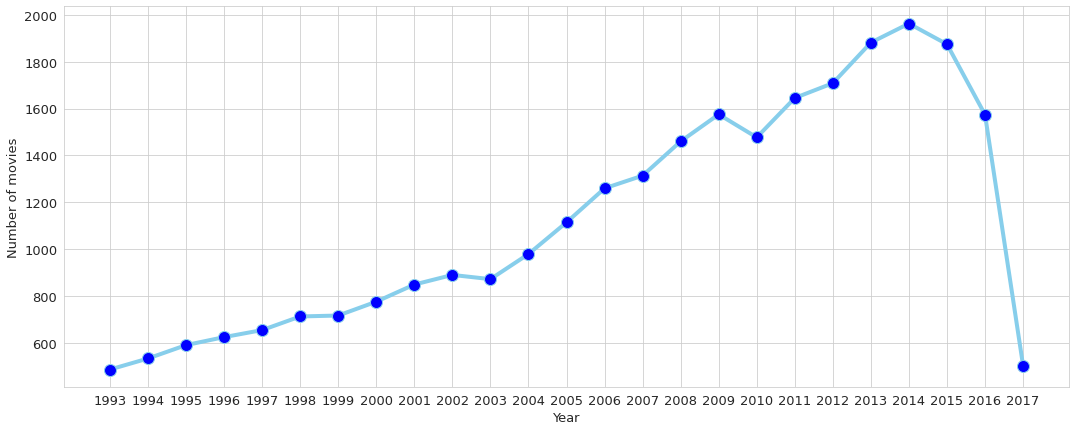

In [58]:
movies_by_year = df.groupby('year')['title'].count().drop(labels='NaT')
movies_by_year=movies_by_year.tail(25)
plt.figure(figsize=(18,7))
plt.xlabel('Year')
plt.ylabel('Number of movies')
plt.plot(movies_by_year,marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4);

### Most Common words in Title and Overview

In [59]:
df['title'] = df['title'].astype('str')
df['overview'] = df['overview'].astype('str')

In [60]:
titles = ' '.join(df['title'])
overviews = ' '.join(df['overview'])

In [61]:
titles[:400]

'Toy Story Jumanji Grumpier Old Men Waiting to Exhale Father of the Bride Part II Heat Sabrina Tom and Huck Sudden Death GoldenEye The American President Dracula: Dead and Loving It Balto Nixon Cutthroat Island Casino Sense and Sensibility Four Rooms Ace Ventura: When Nature Calls Money Train Get Shorty Copycat Assassins Powder Leaving Las Vegas Othello Now and Then Persuasion The City of Lost Chil'

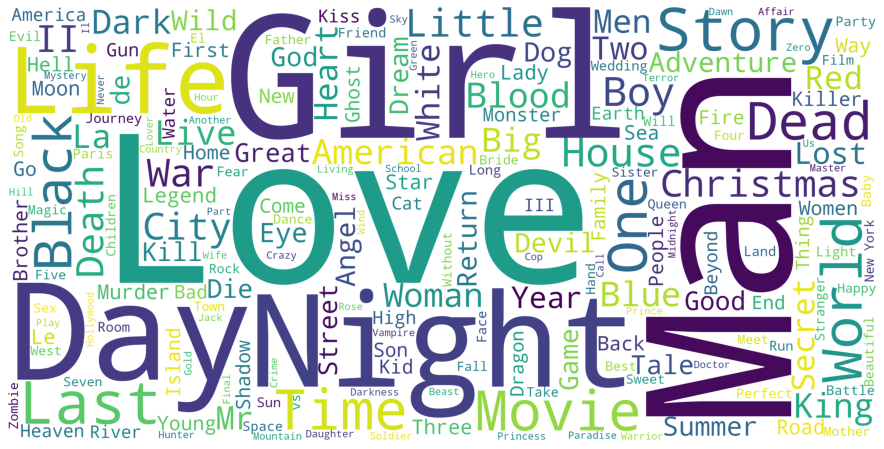

In [62]:
title_wc = WordCloud(stopwords=STOPWORDS, background_color='white', height=1500, width=3000).generate(titles)
plt.figure(figsize=(16,8))
plt.imshow(title_wc)
plt.axis('off')
plt.show();

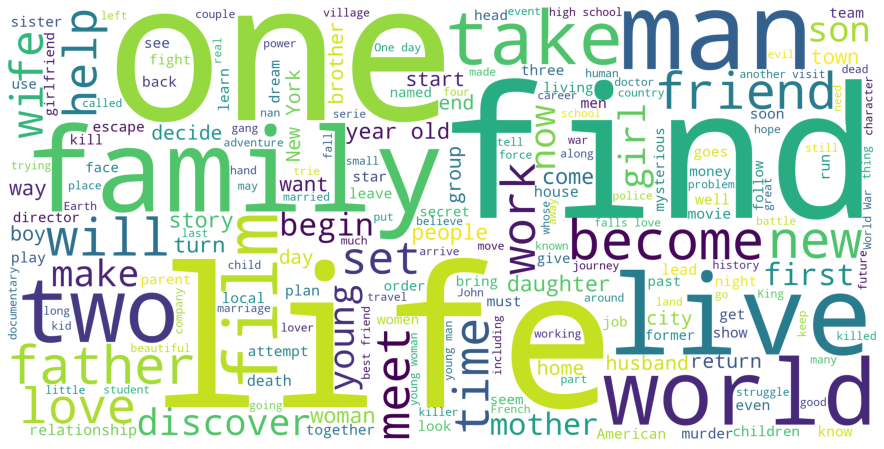

In [63]:
overview_wc = WordCloud(stopwords=STOPWORDS, background_color='white', height=1500, width=3000).generate(overviews)
plt.figure(figsize=(16,8))
plt.imshow(overview_wc)
plt.axis('off')
plt.show()

### Revenue

In [64]:
df['revenue'].describe()

count    7.395000e+03
mean     6.889914e+07
std      1.465243e+08
min      1.000000e+00
25%      2.403104e+06
50%      1.686358e+07
75%      6.748946e+07
max      2.787965e+09
Name: revenue, dtype: float64

In [65]:
sns.set_style("white")

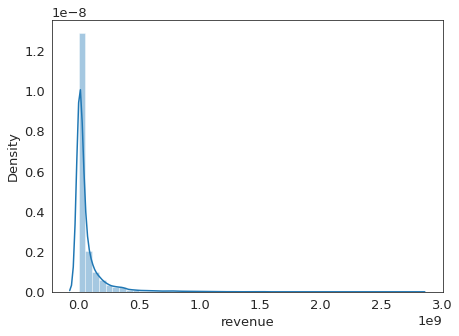

In [66]:
plt.figure(figsize=(7,5))
sns.distplot(df[df['revenue'].notnull()]['revenue']);

#### Highest Grossing Movies

In [67]:
highest_gross_movies = df[['year', 'title', 'revenue']].sort_values('revenue', ascending=False).head(10)
pd.set_option('display.max_colwidth', 50)
highest_gross_movies

,year,title,revenue
14551,2009,Avatar,2.787965e+09
26555,2015,Star Wars: The Force Awakens,2.068224e+09
1639,1997,Titanic,1.845034e+09
17818,2012,The Avengers,1.519558e+09
25084,2015,Jurassic World,1.513529e+09
28830,2015,Furious 7,1.506249e+09
26558,2015,Avengers: Age of Ultron,1.405404e+09
17437,2011,Harry Potter and the Deathly Hallows: Part 2,1.342000e+09
22110,2013,Frozen,1.274219e+09
42222,2017,Beauty and the Beast,1.262886e+09


### Franchise Movies

In [68]:
fran.head()

,title,franchise_name,revenue
0,Toy Story,Toy Story Collection,373554033.0
2,Grumpier Old Men,Grumpy Old Men Collection,0.0
4,Father of the Bride Part II,Father of the Bride Collection,76578911.0
9,GoldenEye,James Bond Collection,352194034.0
12,Balto,Balto Collection,11348324.0


In [69]:
franPivot = fran.pivot_table(index='franchise_name',values='revenue',aggfunc={'revenue':['sum', 'count']}).reset_index()

#### Highest Grossing Franchise Movies

In [70]:
franPivot.sort_values('sum', ascending=False).head(10)

,franchise_name,count,sum
551,Harry Potter Collection,8,7.707367e+09
1157,Star Wars Collection,8,7.434495e+09
645,James Bond Collection,26,7.106970e+09
1314,The Fast and the Furious Collection,8,5.125099e+09
965,Pirates of the Caribbean Collection,5,4.521577e+09
1546,Transformers Collection,5,4.366101e+09
325,Despicable Me Collection,6,3.691070e+09
1487,The Twilight Collection,5,3.342107e+09
609,Ice Age Collection,5,3.216709e+09
665,Jurassic Park Collection,4,3.031484e+09


### Production Companies

In [71]:
df['production_companies'] = df['production_companies'].apply(lambda y: [j['name'] for j in y] if isinstance(y, list) else [])
companies = df.apply(lambda y: pd.Series(y['production_companies']),axis=1).stack().reset_index(level=1, drop=True)
companies.name = 'companies'

In [72]:
companies_df = df.drop('production_companies', axis=1).join(companies)

In [73]:
total_companies = pd.DataFrame(companies_df.groupby('companies')['revenue'].sum().sort_values(ascending=False))
total_companies.columns = ['Total revenue']
count_companies = pd.DataFrame(companies_df.groupby('companies')['revenue'].count().sort_values(ascending=False))
count_companies.columns = ['Number']

In [74]:
companies_pivot = pd.concat((total_companies, count_companies), axis=1,sort=False)

#### Highest Earning Production Companies

In [75]:
companies_pivot.sort_values('Total revenue', ascending=False).head(10)

,Total revenue,Number
Warner Bros.,6.352519e+10,491
Universal Pictures,5.525919e+10,463
Paramount Pictures,4.880819e+10,395
Twentieth Century Fox Film Corporation,4.768775e+10,341
Walt Disney Pictures,4.083727e+10,147
Columbia Pictures,3.227974e+10,236
New Line Cinema,2.217339e+10,198
Amblin Entertainment,1.734372e+10,68
DreamWorks SKG,1.547575e+10,78
Dune Entertainment,1.500379e+10,62


### Most Common Original Languages

In [76]:
df['original_language'].value_counts().count()

89

In [77]:
languages_df = pd.DataFrame(df['original_language'].value_counts())
languages_df['language'] = languages_df.index
languages_df.columns = ['number', 'language']
languages_df.reset_index(drop=True,inplace=True)
languages_df.head()

,number,language
0,31952,en
1,2418,fr
2,1511,it
3,1342,ja
4,1074,de


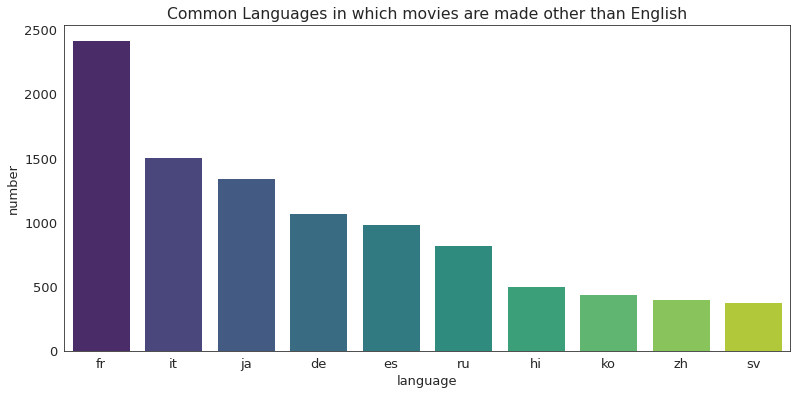

In [78]:
plt.figure(figsize=(13,6))
sns.barplot(x='language', y='number', data=languages_df.iloc[1:11],palette='viridis')
plt.title('Common Languages in which movies are made other than English')
plt.show()

## <b>Simple Recommmender System</b>

In [79]:
vote_avg_mean = df['vote_average'].mean()
print(vote_avg_mean)

6.015503065443346


In [80]:
# The minimum number of votes required to be in the chart is m
m = df['vote_count'].quantile(0.92)
print(m)

231.0


In [81]:
selected_movies =df.copy().loc[df['vote_count'] >= m]
selected_movies.shape

(3605, 13)

In [82]:
# Computes the weighted rating of each movie based on the IMDB formula
def weighted_rating(z, m=m, C=vote_avg_mean):
    v = z['vote_count']
    R = z['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [83]:
selected_movies['w_rating'] = selected_movies.apply(weighted_rating, axis=1)

In [84]:
# Sort movies based on weighted rating calculated above and display the top 20 movies
selected_movies = selected_movies.sort_values('w_rating', ascending=False)
selected_movies[['title', 'vote_count', 'vote_average', 'w_rating']].head(20)

,title,vote_count,vote_average,w_rating
314,The Shawshank Redemption,8358.0,8.5,8.433180
834,The Godfather,6024.0,8.5,8.408246
10309,Dilwale Dulhania Le Jayenge,661.0,9.1,8.301212
12481,The Dark Knight,12269.0,8.3,8.257782
2843,Fight Club,9678.0,8.3,8.246743
292,Pulp Fiction,8670.0,8.3,8.240712
522,Schindler's List,4436.0,8.3,8.186925
23673,Whiplash,4376.0,8.3,8.185453
5481,Spirited Away,3968.0,8.3,8.174323
2211,Life Is Beautiful,3643.0,8.3,8.163779


## <b>Content Based Recommendation System</b>

In [85]:
links2 = links[links['tmdbId'].notnull()]['tmdbId'].astype('int')

In [86]:
df['genres'].head()

0     [Animation, Comedy, Family]
1    [Adventure, Fantasy, Family]
2               [Romance, Comedy]
3        [Comedy, Drama, Romance]
4                        [Comedy]
Name: genres, dtype: object

In [87]:
keywords_df['id'] = keywords_df['id'].astype('int')
cast_crew['id'] = cast_crew['id'].astype('int')
df['id'] = df['id'].astype('int')

In [88]:
df.shape

(45014, 13)

In [89]:
# Merging cast and crew data and keywords data with movies metadata
df = df.merge(cast_crew, on='id')
df = df.merge(keywords_df, on='id')
df2 = df[df['id'].isin(links2)]
df2.shape

(9198, 16)

In [90]:
df2['cast'] = df2['cast'].apply(literal_eval)
df2['crew'] = df2['crew'].apply(literal_eval)
df2['keywords'] = df2['keywords'].apply(literal_eval)

In [91]:
def director_name(a):
    for j in a:
        if j['job'] == 'Director':
            return j['name']
    return np.nan

In [92]:
df2['director'] = df2['crew'].apply(director_name)

In [93]:
df2['keywords'] = df2['keywords'].apply(lambda y: [i['name'] for i in y] if isinstance(y, list) else [])

In [94]:
df2['cast'] = df2['cast'].apply(lambda y: [i['name'] for i in y] if isinstance(y, list) else [])

In [95]:
df2['cast'] = df2['cast'].apply(lambda y: y[:3] if len(y) >=3 else y)

In [96]:
df2['cast'].head()

0                  [Tom Hanks, Tim Allen, Don Rickles]
1       [Robin Williams, Jonathan Hyde, Kirsten Dunst]
2           [Walter Matthau, Jack Lemmon, Ann-Margret]
3    [Whitney Houston, Angela Bassett, Loretta Devine]
4           [Steve Martin, Diane Keaton, Martin Short]
Name: cast, dtype: object

In [97]:
df2['cast'] = df2['cast'].apply(lambda y: [str.lower(i.replace(" ", "")) for i in y])
df2['director'] = df2['director'].astype('str').apply(lambda y: str.lower(y.replace(" ", "")))

In [98]:
df2['director'] = df2['director'].apply(lambda y: [y,y,y])

In [99]:
df2.drop(['crew','tagline','overview'],axis=1,inplace=True)

In [100]:
df2.head()

,title,belongs_to_collection,genres,id,original_language,popularity,production_companies,revenue,vote_average,vote_count,year,cast,keywords,director
0,Toy Story,"{'id': 10194, 'name': 'Toy Story Collection', ...","[Animation, Comedy, Family]",862,en,21.946943,[Pixar Animation Studios],373554033.0,7.7,5415.0,1995,"[tomhanks, timallen, donrickles]","[jealousy, toy, boy, friendship, friends, riva...","[johnlasseter, johnlasseter, johnlasseter]"
1,Jumanji,NaN,"[Adventure, Fantasy, Family]",8844,en,17.015539,"[TriStar Pictures, Teitler Film, Interscope Co...",262797249.0,6.9,2413.0,1995,"[robinwilliams, jonathanhyde, kirstendunst]","[board game, disappearance, based on children'...","[joejohnston, joejohnston, joejohnston]"
2,Grumpier Old Men,"{'id': 119050, 'name': 'Grumpy Old Men Collect...","[Romance, Comedy]",15602,en,11.712900,"[Warner Bros., Lancaster Gate]",NaN,6.5,92.0,1995,"[waltermatthau, jacklemmon, ann-margret]","[fishing, best friend, duringcreditsstinger, o...","[howarddeutch, howarddeutch, howarddeutch]"
3,Waiting to Exhale,NaN,"[Comedy, Drama, Romance]",31357,en,3.859495,[Twentieth Century Fox Film Corporation],81452156.0,6.1,34.0,1995,"[whitneyhouston, angelabassett, lorettadevine]","[based on novel, interracial relationship, sin...","[forestwhitaker, forestwhitaker, forestwhitaker]"
4,Father of the Bride Part II,"{'id': 96871, 'name': 'Father of the Bride Col...",[Comedy],11862,en,8.387519,"[Sandollar Productions, Touchstone Pictures]",76578911.0,5.7,173.0,1995,"[stevemartin, dianekeaton, martinshort]","[baby, midlife crisis, confidence, aging, daug...","[charlesshyer, charlesshyer, charlesshyer]"


In [101]:
key_words = df2.apply(lambda z: pd.Series(z['keywords']),axis=1).stack().reset_index(level=1, drop=True)
key_words=key_words.value_counts()
key_words.name='keywords'

In [102]:
key_words

independent film        609
woman director          549
murder                  399
duringcreditsstinger    327
based on novel          318
                       ... 
woman smoking             1
investor                  1
hotel manager             1
ifc midnight              1
bank cashier              1
Name: keywords, Length: 12933, dtype: int64

In [103]:
key_words=key_words[key_words>1]

In [104]:
Stemmer = SnowballStemmer('english')
Stemmer.stem('friends')

'friend'

In [105]:
def select_keywords(y):
    keyword_list = []
    for i in y:
        if i in key_words:
            keyword_list.append(i)
    return keyword_list

In [106]:
df2['keywords'] = df2['keywords'].apply(select_keywords)
df2['keywords'] = df2['keywords'].apply(lambda y: [Stemmer.stem(i) for i in y])

In [107]:
df2['keywords'] = df2['keywords'].apply(lambda y: [str.lower(i.replace(" ", "")) for i in y])

In [108]:
# Combining columns of cast, director, keywords and genres 
df2['combined_columns'] = df2['cast'] + df2['director'] +df2['keywords'] + df2['genres']
df2['combined_columns'] = df2['combined_columns'].apply(lambda y: ' '.join(y))

In [109]:
df2['combined_columns']

0        tomhanks timallen donrickles johnlasseter john...
1        robinwilliams jonathanhyde kirstendunst joejoh...
2        waltermatthau jacklemmon ann-margret howarddeu...
3        whitneyhouston angelabassett lorettadevine for...
4        stevemartin dianekeaton martinshort charlesshy...
                               ...                        
40596    sidneypoitier wendycrewson jayo.sanders greggc...
40815    akshaykumar ileanad'cruz eshagupta tinusureshd...
40868    hrithikroshan poojahegde kabirbedi ashutoshgow...
41031    hirokihasegawa yutakatakenouchi satomiishihara...
41305    paulmccartney ringostarr johnlennon ronhoward ...
Name: combined_columns, Length: 9198, dtype: object

In [110]:
count_vectorizer = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
CountMatrix = count_vectorizer.fit_transform(df2['combined_columns'])

In [111]:
cosine_similarities = cosine_similarity(CountMatrix, CountMatrix)

In [112]:
df2.head()

,title,belongs_to_collection,genres,id,original_language,popularity,production_companies,revenue,vote_average,vote_count,year,cast,keywords,director,combined_columns
0,Toy Story,"{'id': 10194, 'name': 'Toy Story Collection', ...","[Animation, Comedy, Family]",862,en,21.946943,[Pixar Animation Studios],373554033.0,7.7,5415.0,1995,"[tomhanks, timallen, donrickles]","[jealousi, toy, boy, friendship, friend, rival...","[johnlasseter, johnlasseter, johnlasseter]",tomhanks timallen donrickles johnlasseter john...
1,Jumanji,NaN,"[Adventure, Fantasy, Family]",8844,en,17.015539,"[TriStar Pictures, Teitler Film, Interscope Co...",262797249.0,6.9,2413.0,1995,"[robinwilliams, jonathanhyde, kirstendunst]","[boardgam, disappear, basedonchildren'sbook, n...","[joejohnston, joejohnston, joejohnston]",robinwilliams jonathanhyde kirstendunst joejoh...
2,Grumpier Old Men,"{'id': 119050, 'name': 'Grumpy Old Men Collect...","[Romance, Comedy]",15602,en,11.712900,"[Warner Bros., Lancaster Gate]",NaN,6.5,92.0,1995,"[waltermatthau, jacklemmon, ann-margret]","[fish, bestfriend, duringcreditssting]","[howarddeutch, howarddeutch, howarddeutch]",waltermatthau jacklemmon ann-margret howarddeu...
3,Waiting to Exhale,NaN,"[Comedy, Drama, Romance]",31357,en,3.859495,[Twentieth Century Fox Film Corporation],81452156.0,6.1,34.0,1995,"[whitneyhouston, angelabassett, lorettadevine]","[basedonnovel, interracialrelationship, single...","[forestwhitaker, forestwhitaker, forestwhitaker]",whitneyhouston angelabassett lorettadevine for...
4,Father of the Bride Part II,"{'id': 96871, 'name': 'Father of the Bride Col...",[Comedy],11862,en,8.387519,"[Sandollar Productions, Touchstone Pictures]",76578911.0,5.7,173.0,1995,"[stevemartin, dianekeaton, martinshort]","[babi, midlifecrisi, confid, age, daughter, mo...","[charlesshyer, charlesshyer, charlesshyer]",stevemartin dianekeaton martinshort charlesshy...


In [113]:
df2 = df2.reset_index()
df2 = df2.reset_index()

In [114]:
df2.drop('index',axis=1,inplace=True)

In [115]:
df2.rename(columns={"level_0": "index1"},inplace=True)

In [116]:
df2.head()

,index1,title,belongs_to_collection,genres,id,original_language,popularity,production_companies,revenue,vote_average,vote_count,year,cast,keywords,director,combined_columns
0,0,Toy Story,"{'id': 10194, 'name': 'Toy Story Collection', ...","[Animation, Comedy, Family]",862,en,21.946943,[Pixar Animation Studios],373554033.0,7.7,5415.0,1995,"[tomhanks, timallen, donrickles]","[jealousi, toy, boy, friendship, friend, rival...","[johnlasseter, johnlasseter, johnlasseter]",tomhanks timallen donrickles johnlasseter john...
1,1,Jumanji,NaN,"[Adventure, Fantasy, Family]",8844,en,17.015539,"[TriStar Pictures, Teitler Film, Interscope Co...",262797249.0,6.9,2413.0,1995,"[robinwilliams, jonathanhyde, kirstendunst]","[boardgam, disappear, basedonchildren'sbook, n...","[joejohnston, joejohnston, joejohnston]",robinwilliams jonathanhyde kirstendunst joejoh...
2,2,Grumpier Old Men,"{'id': 119050, 'name': 'Grumpy Old Men Collect...","[Romance, Comedy]",15602,en,11.712900,"[Warner Bros., Lancaster Gate]",NaN,6.5,92.0,1995,"[waltermatthau, jacklemmon, ann-margret]","[fish, bestfriend, duringcreditssting]","[howarddeutch, howarddeutch, howarddeutch]",waltermatthau jacklemmon ann-margret howarddeu...
3,3,Waiting to Exhale,NaN,"[Comedy, Drama, Romance]",31357,en,3.859495,[Twentieth Century Fox Film Corporation],81452156.0,6.1,34.0,1995,"[whitneyhouston, angelabassett, lorettadevine]","[basedonnovel, interracialrelationship, single...","[forestwhitaker, forestwhitaker, forestwhitaker]",whitneyhouston angelabassett lorettadevine for...
4,4,Father of the Bride Part II,"{'id': 96871, 'name': 'Father of the Bride Col...",[Comedy],11862,en,8.387519,"[Sandollar Productions, Touchstone Pictures]",76578911.0,5.7,173.0,1995,"[stevemartin, dianekeaton, martinshort]","[babi, midlifecrisi, confid, age, daughter, mo...","[charlesshyer, charlesshyer, charlesshyer]",stevemartin dianekeaton martinshort charlesshy...


In [117]:
def getIndex(title):
    return df2[df2.title == title]["index1"].values[0]
def getTitle(indx):
    return df2[df2.index1 == indx]["title"].values[0]
    

In [118]:
def recommendations(user_choice_movie):
  movie_list=[]
  movie_index = getIndex(user_choice_movie)
  similar_movies = cosine_similarities[movie_index]
  movies_new= list(enumerate(similar_movies))
  movies_new = sorted(movies_new, key=lambda x: x[1], reverse=True)[1:]
  i=0
  for movie in movies_new:
      movie_list.append(getTitle(movie[0]))
      i=i+1
      if i>20:
          break
  return pd.DataFrame(movie_list,columns =['Recommendations for '+user_choice_movie+":"])

In [119]:
recommendations("Toy Story")

,Recommendations for Toy Story:
0,Luxo Jr.
1,Toy Story 2
2,Cars 2
3,A Bug's Life
4,Cars
5,Toy Story of Terror!
6,Toy Story 3
7,Creature Comforts
8,"Monsters, Inc."
9,Meet the Deedles


In [120]:
recommendations('Harry Potter and the Deathly Hallows: Part 2')

,Recommendations for Harry Potter and the Deathly Hallows: Part 2:
0,Harry Potter and the Half-Blood Prince
1,Harry Potter and the Deathly Hallows: Part 1
2,Harry Potter and the Order of the Phoenix
3,The Legend of Tarzan
4,The Girl in the Café
5,Harry Potter and the Philosopher's Stone
6,Harry Potter and the Goblet of Fire
7,Harry Potter and the Chamber of Secrets
8,Oz: The Great and Powerful
9,Harry Potter and the Prisoner of Azkaban


## **Collaborative Filtering**

In [121]:
reader = Reader()

In [122]:
ratings_df.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [132]:
ratings_data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

In [152]:
svd = SVD()
cross_validate(svd, ratings_data, measures=['RMSE', 'MAE'], cv=10, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8894  0.8886  0.8899  0.8881  0.8784  0.8984  0.9050  0.9040  0.8872  0.8983  0.8927  0.0080  
MAE (testset)     0.6812  0.6853  0.6836  0.6851  0.6785  0.6934  0.6934  0.6943  0.6811  0.6931  0.6869  0.0058  
Fit time          5.49    5.50    5.48    5.44    5.50    5.48    5.46    5.51    5.47    5.48    5.48    0.02    
Test time         0.07    0.07    0.07    0.07    0.08    0.07    0.07    0.26    0.07    0.07    0.09    0.06    


{'fit_time': (5.492206335067749,
  5.4970598220825195,
  5.475900173187256,
  5.44301700592041,
  5.496695518493652,
  5.47516393661499,
  5.463324546813965,
  5.51019549369812,
  5.474067211151123,
  5.484404563903809),
 'test_mae': array([0.68122919, 0.68534634, 0.68360358, 0.68510121, 0.67849644,
        0.6934304 , 0.69343896, 0.69434541, 0.68106426, 0.69312653]),
 'test_rmse': array([0.88938895, 0.88863564, 0.88991193, 0.88811143, 0.87835725,
        0.89843605, 0.90498634, 0.9039663 , 0.88723349, 0.89831826]),
 'test_time': (0.07292437553405762,
  0.07080650329589844,
  0.07337141036987305,
  0.07254171371459961,
  0.08052659034729004,
  0.07129764556884766,
  0.07250332832336426,
  0.2644381523132324,
  0.07156634330749512,
  0.07490730285644531)}

In [164]:
# Splitting of ratings data into train set and test set
trainset, testset = train_test_split(ratings_data, test_size=0.25)
predictions = svd.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.8994


0.8993517223839099

In [165]:
predictions[:5]

[Prediction(uid=518, iid=2240, r_ui=3.0, est=3.6669357533035254, details={'was_impossible': False}),
 Prediction(uid=160, iid=2875, r_ui=3.0, est=3.6844890770121452, details={'was_impossible': False}),
 Prediction(uid=102, iid=125, r_ui=4.0, est=4.32051812753859, details={'was_impossible': False}),
 Prediction(uid=431, iid=3967, r_ui=5.0, est=4.194171602343794, details={'was_impossible': False}),
 Prediction(uid=468, iid=3624, r_ui=2.0, est=2.5005928673216644, details={'was_impossible': False})]

In [166]:
predictions[16]

Prediction(uid=405, iid=1927, r_ui=4.0, est=3.804386166017822, details={'was_impossible': False})

In [167]:
ratings_df[(ratings_df['userId'] == 405) & (ratings_df['movieId'] == 1927)]

,userId,movieId,rating
55971,405,1927,4.0


In [170]:
svd.predict(405,1927,4.0)

Prediction(uid=405, iid=1927, r_ui=4.0, est=3.804386166017822, details={'was_impossible': False})

## <b>Hybrid Recommender System</b>

In [142]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [143]:
def To_Integer(num):
    try:
        return int(num)
    except:
        return np.nan

In [144]:
Id_df = links[['movieId', 'tmdbId']]
Id_df['tmdbId'] = Id_df['tmdbId'].apply(To_Integer)
Id_df.columns = ['movieId', 'id']
Id_df =Id_df.merge(df2[['title', 'id']], on='id').set_index('title')

In [145]:
Id_df

,movieId,id
title,,
Toy Story,1,862.0
Jumanji,2,8844.0
Grumpier Old Men,3,15602.0
Waiting to Exhale,4,31357.0
Father of the Bride Part II,5,11862.0
...,...,...
The Last Brickmaker in America,161944,159550.0
Rustom,162542,392572.0
Mohenjo Daro,162672,402672.0


In [146]:
Index_map_df = Id_df.set_index('id')

In [147]:
Index_map_df

,movieId
id,
862.0,1
8844.0,2
15602.0,3
31357.0,4
11862.0,5
...,...
159550.0,161944
392572.0,162542
402672.0,162672


In [148]:
titles = df2['title']
indices = pd.Series(df2.index, index=df2['title'])

In [149]:
def hybrid_recommend(user_id, user_choice_movie):
    indx = indices[user_choice_movie]
    movie_similarities = list(enumerate(cosine_similarities[int(indx)]))
    movie_similarities = sorted(movie_similarities, key=lambda z: z[1], reverse=True)
    movie_similarities = movie_similarities[1:26]
    movie_indices = [i[0] for i in movie_similarities]
    movie_list = df2.iloc[movie_indices][['year','title', 'vote_count', 'vote_average','id']]
    movie_list['est'] = movie_list['id'].apply(lambda y: svd.predict(user_id, Index_map_df.loc[y]['movieId']).est)
    movie_list = movie_list.sort_values('est', ascending=False).head(20)
    return movie_list

In [150]:
hybrid_recommend(3,'Avengers: Age of Ultron')

,year,title,vote_count,vote_average,id,est
6997,2008,Iron Man,8951.0,7.4,1726,3.832462
8609,2014,Captain America: The Winter Soldier,5881.0,7.6,100402,3.824315
7955,2012,The Avengers,12000.0,7.4,24428,3.753463
7910,2011,Captain America: The First Avenger,7174.0,6.6,1771,3.682896
8385,2013,Star Trek Into Darkness,4479.0,7.4,54138,3.678766
8851,2015,Ant-Man,6029.0,7.0,102899,3.646672
6241,2005,Serenity,1287.0,7.4,16320,3.595651
7235,2008,Dr. Horrible's Sing-Along Blog,236.0,7.8,14301,3.525792
4626,2003,X2,3572.0,6.8,36658,3.433489
7587,2010,Iron Man 2,6969.0,6.6,10138,3.387023


In [151]:
hybrid_recommend(20,'Harry Potter and the Chamber of Secrets')

,year,title,vote_count,vote_average,id,est
7908,2011,Harry Potter and the Deathly Hallows: Part 2,6141.0,7.9,12445,3.843674
6343,2005,Harry Potter and the Goblet of Fire,5758.0,7.5,674,3.692344
7333,2009,Harry Potter and the Half-Blood Prince,5435.0,7.4,767,3.628075
7729,2010,Harry Potter and the Deathly Hallows: Part 1,5708.0,7.5,12444,3.542519
5441,2004,Harry Potter and the Prisoner of Azkaban,6037.0,7.7,673,3.504665
1955,1998,Stepmom,286.0,6.9,9441,3.423573
6789,2007,Harry Potter and the Order of the Phoenix,5633.0,7.4,675,3.339080
3833,2001,Harry Potter and the Philosopher's Stone,7188.0,7.5,671,3.328640
447,1993,Mrs. Doubtfire,1638.0,7.0,788,3.240475
851,1971,Bedknobs and Broomsticks,260.0,6.8,12335,3.221555
